## Feature Engineering
- Objective
    - Create an additional feature with a time concept
- Functions to use
    - BigQuery Window(Analytics) Function
    
- Features to add
    - Demand for a given zip_code 1 hour ago, 1 day (=24 hours) ago, and 7 days (=168 hours) ago.
    - A word of caution here
        - Don't just call the window function based on historical data and ask it to get the value 168 hours ago.
        - because there may be empty values.
        - So, create a non-empty time data and then cross join it with zip_code.
        - After that, join the historical demand data by zip_code and datetime.

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
import numpy as np
from sacred import Experiment
from sacred.observers import FileStorageObserver
from sklearn.ensemble import RandomForestRegressor
import json

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='nyctaxi-demand-forecast'

In [4]:
ex = Experiment('nyc-demand-prediction', interactive=True)

experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

### Pre-Processing

In [5]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
), distinct_datetime AS (
# Get only the Datetime as distinct (assuming it's not empty)
  SELECT distinct DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour
  FROM base_data
), distinct_zip_code AS (
# get only zip_code as distinct (assuming no other zip_codes)
  SELECT distinct zip_code
  FROM base_data
), zip_code_datetime_join AS (
  # zip_code와 datetime을 join
  SELECT
    *,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend
  FROM distinct_zip_code  
  CROSS JOIN distinct_datetime
), agg_data AS (
# demand by zip_code, datetime 
  SELECT 
      zip_code,
      DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
      COUNT(*) AS cnt
  FROM base_data 
  GROUP BY zip_code, pickup_hour
), join_output AS (
# zip_code, datetime If the data does not have a demand value attached to it, process 0
  select 
    zip_code_datetime.*, 
    IFNULL(agg_data.cnt, 0) AS cnt
  from zip_code_datetime_join as zip_code_datetime
  LEFT JOIN agg_data
  ON zip_code_datetime.zip_code = agg_data.zip_code and zip_code_datetime.pickup_hour = agg_data.pickup_hour
)
SELECT
  *,
  LAG(cnt, 1) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1h_cnt,
  LAG(cnt, 24) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1d_cnt,
  LAG(cnt, 168) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_7d_cnt,
  LAG(cnt, 336) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING), 2) AS avg_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING), 2) AS avg_21d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING) AS INT64) AS std_14d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING) AS INT64) AS std_21d_cnt
FROM join_output
order by zip_code, pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

CPU times: user 6.76 s, sys: 441 ms, total: 7.2 s
Wall time: 40.9 s


In [6]:
base_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt
278251,14801,2015-01-31 19:00:00+00:00,1,31,5,19,1,0,0,0,0,0,0.01,0.0,0,0
278252,14801,2015-01-31 20:00:00+00:00,1,31,5,20,1,0,0,0,0,0,0.01,0.0,0,0
278253,14801,2015-01-31 21:00:00+00:00,1,31,5,21,1,0,0,1,0,0,0.01,0.0,0,0
278254,14801,2015-01-31 22:00:00+00:00,1,31,5,22,1,0,0,0,0,0,0.01,0.0,0,0
278255,14801,2015-01-31 23:00:00+00:00,1,31,5,23,1,0,0,0,0,0,0.01,0.0,0,0


In [7]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [9]:
def split_train_and_test(df, date):
    """
    Divide by train_df, test_df functions on a dataframe
    
    df : time series dataframe
    date : reference point date
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Split Train / Test

In [10]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [11]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt,zip_code_le
278059,14801,2015-01-23 19:00:00+00:00,1,23,4,19,0,0,0,0,0,0,0.0,0.0,0,0,373
278060,14801,2015-01-23 20:00:00+00:00,1,23,4,20,0,0,0,0,0,0,0.0,0.0,0,0,373
278061,14801,2015-01-23 21:00:00+00:00,1,23,4,21,0,0,0,0,0,0,0.0,0.0,0,0,373
278062,14801,2015-01-23 22:00:00+00:00,1,23,4,22,0,0,0,0,0,0,0.0,0.0,0,0,373
278063,14801,2015-01-23 23:00:00+00:00,1,23,4,23,0,0,0,0,0,0,0.0,0.0,0,0,373


- Delete unused columns

In [12]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [13]:
train_df.head(2)

,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt,zip_code_le
0,1,1,3,0,0,1221,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,0
1,1,1,3,1,0,1151,1221,<NA>,<NA>,<NA>,1221.0,1221.0,<NA>,<NA>,0


In [14]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [15]:
train_df = train_df.fillna(method='backfill')
test_df = test_df.fillna(method='backfill')

In [180]:
x_train = train_df.copy()
x_test = test_df.copy()

In [181]:
len(x_train)

206448

In [182]:
len(x_test)

71808

- Why so much data?
    - Lots of empty values by zip_code, datetime

### Modeling

In [149]:
def evaluation(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-7
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score


In [119]:
@ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [120]:
@ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)


In [121]:
@ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [122]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.DataFrame(json_data['metrics']['values'][0]['values'])

    output_df = pd.concat([output_df, metric_df], axis=1)
    return output_df

In [123]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/run.json') as json_file:
        json_data = json.load(json_file)
    output = pd.DataFrame(json_data['result'])
    return output

In [95]:
%%time
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "21"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 201793697.17805648}, 'mae': {'score': 7.0313795120320846}, 'mse': {'score': 1103.9561966633244}}
INFO - nyc-demand-prediction - Completed after 0:00:02


CPU times: user 8.3 s, sys: 185 ms, total: 8.48 s
Wall time: 2.02 s


In [124]:
experiment_result.config

{'n_estimators': 10, 'n_jobs': -1, 'seed': 853261645}

In [125]:
parsing_output(21)

,mae,mape,mse
score,7.03138,2.017937e+08,1103.956197


In [24]:
parsing_output(5)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,5,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 635...",35.292444,182.606663,12276.947911


In [25]:
parsing_output(4)

,model_name,experiment_num,config,mae,mape,mse
score,LGBMRegressor,4,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",47.901979,412.772891,13734.183106


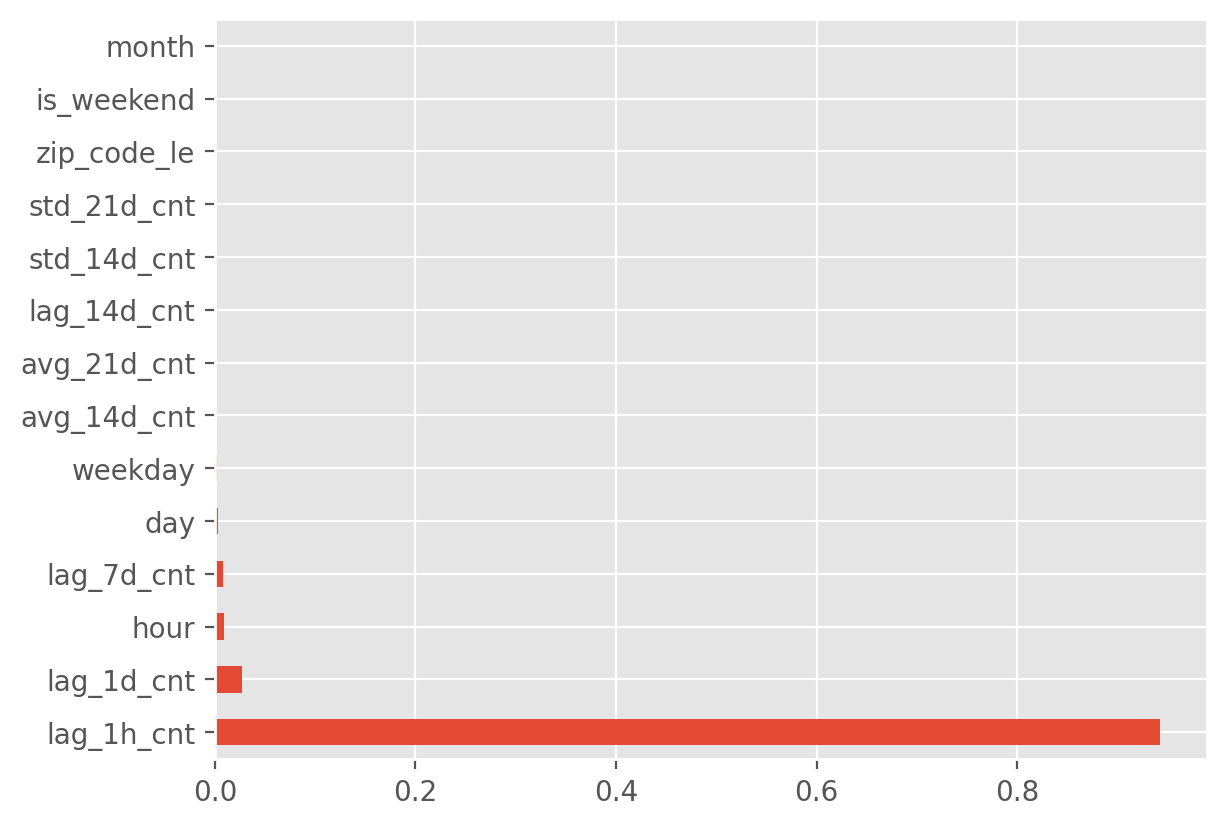

In [126]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

### Analyze the results
- Which algorithm performed best?

In [27]:
parsing_output(3)

,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,3,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",57.678736,538.520173,16512.330211


In [28]:
parsing_output(4)

,model_name,experiment_num,config,mae,mape,mse
score,LGBMRegressor,4,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",47.901979,412.772891,13734.183106


In [29]:
parsing_output(5)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,5,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 635...",35.292444,182.606663,12276.947911


In [127]:
parsing_output(21)

,mae,mape,mse
score,7.03138,2.017937e+08,1103.956197


- MAPE
    - None because y_true has a value of 0
    - While MAPE has the advantage of being less susceptible to outliers and easier to interpret, it will divide by zero if the actual value is zero => To avoid the division by zero error, we can add a very small value 'eplison' to the denominator.
    - [good article on MAPE disadvantages](https://stats.stackexchange.com/questions/299712/what-are-the-shortcomings-of-the-mean-absolute-percentage-error-mape)
    - [good article on MAPE disadvantages2](https://stats.stackexchange.com/questions/280464/is-mape-a-good-error-measurement-statistic-and-what-alternatives-are-there)
- Workaround.
    - Add Epsilon to the denominator: [see forecasting metrics.py](https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9)
    - How to exclude invalids like Inf/None
    - How to use the new metric
        - [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error), [MASE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error)

### Data Recovery
- Reverse encoding label encoding, deleted data, datetime, etc.

In [184]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred
test_df['year'] = 2015
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

In [185]:
test_df = test_df.set_index('datetime')

### Differences by Datetime

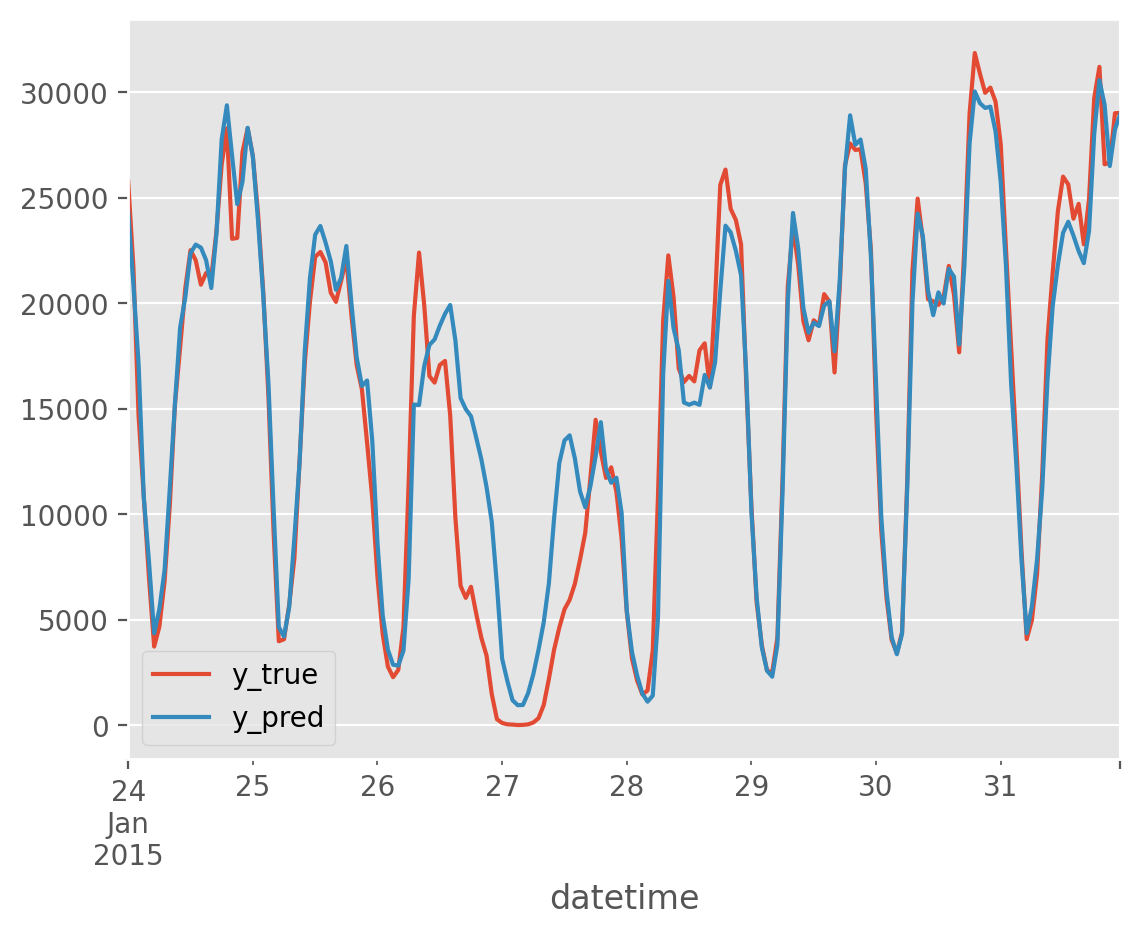

In [186]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot();

### Differences by Zip code

In [187]:
def visualize_output_by_zipcode(df):
    def view_images(zip_code):
        data = df.loc[df['zip_code'] == str(zip_code)][['y_true', 'y_pred']]
        try:
            ax = data.plot();
            ax.set_title(f'zip_code : {zip_code}')
        except:
            pass
        
    interact(view_images, zip_code=(10001, 10200))

In [188]:
visualize_output_by_zipcode(test_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

### Differences by Hour

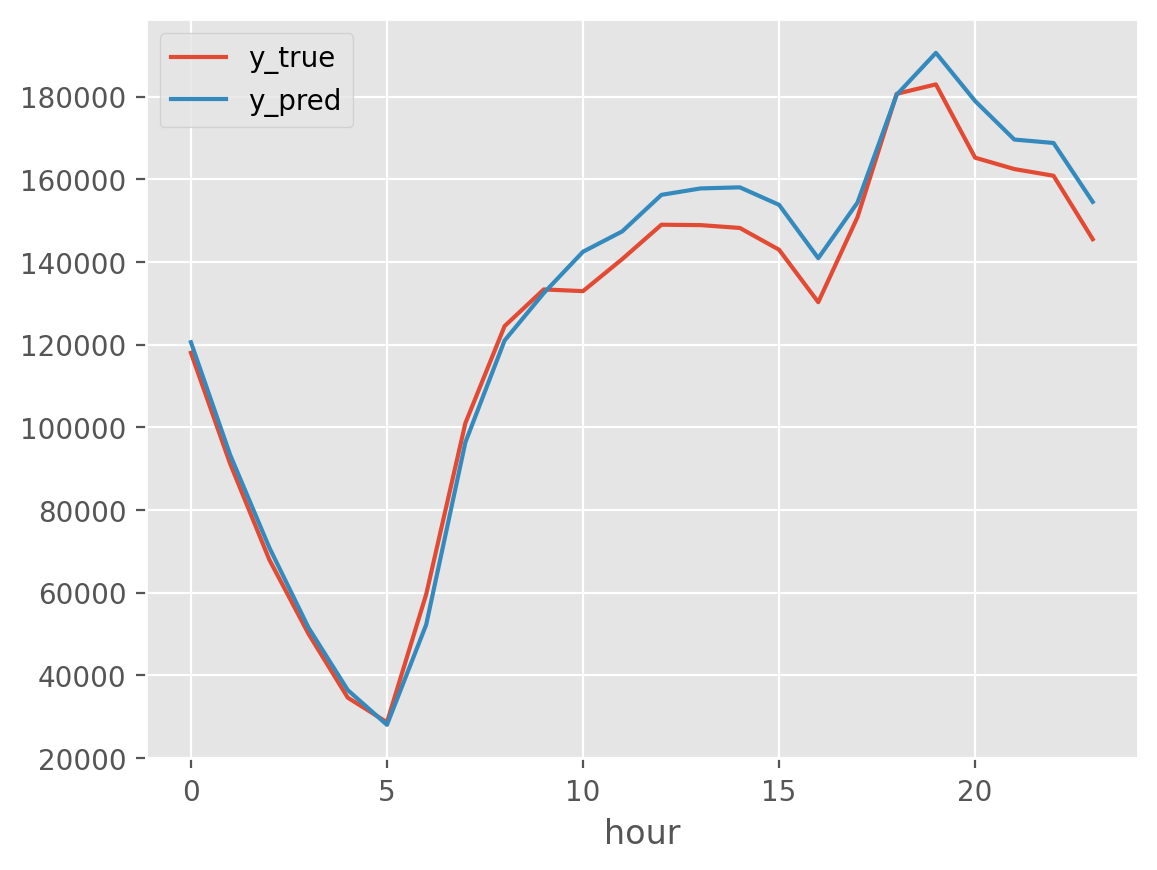

In [189]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot();

### Differences by Weekday

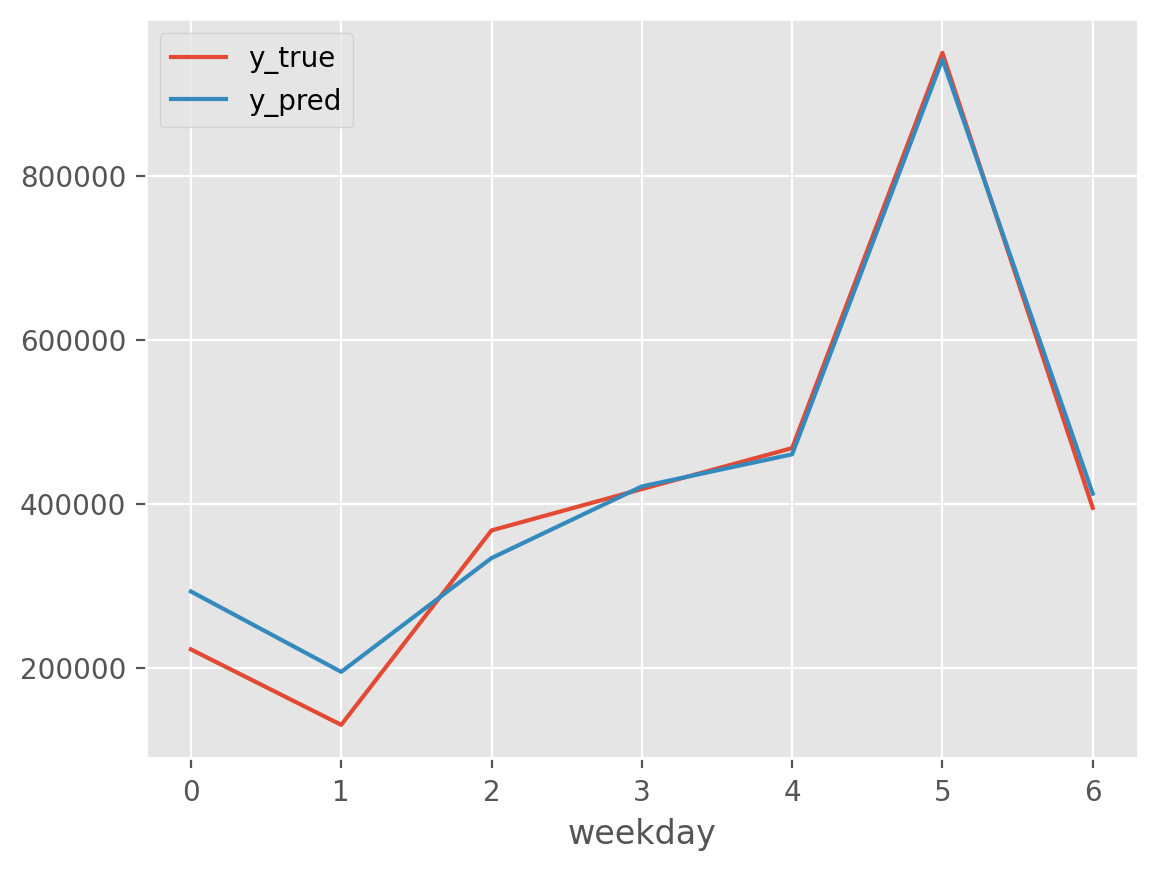

In [190]:
test_df[['weekday','y_true', 'y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot();

### Differences by weekday/weekend

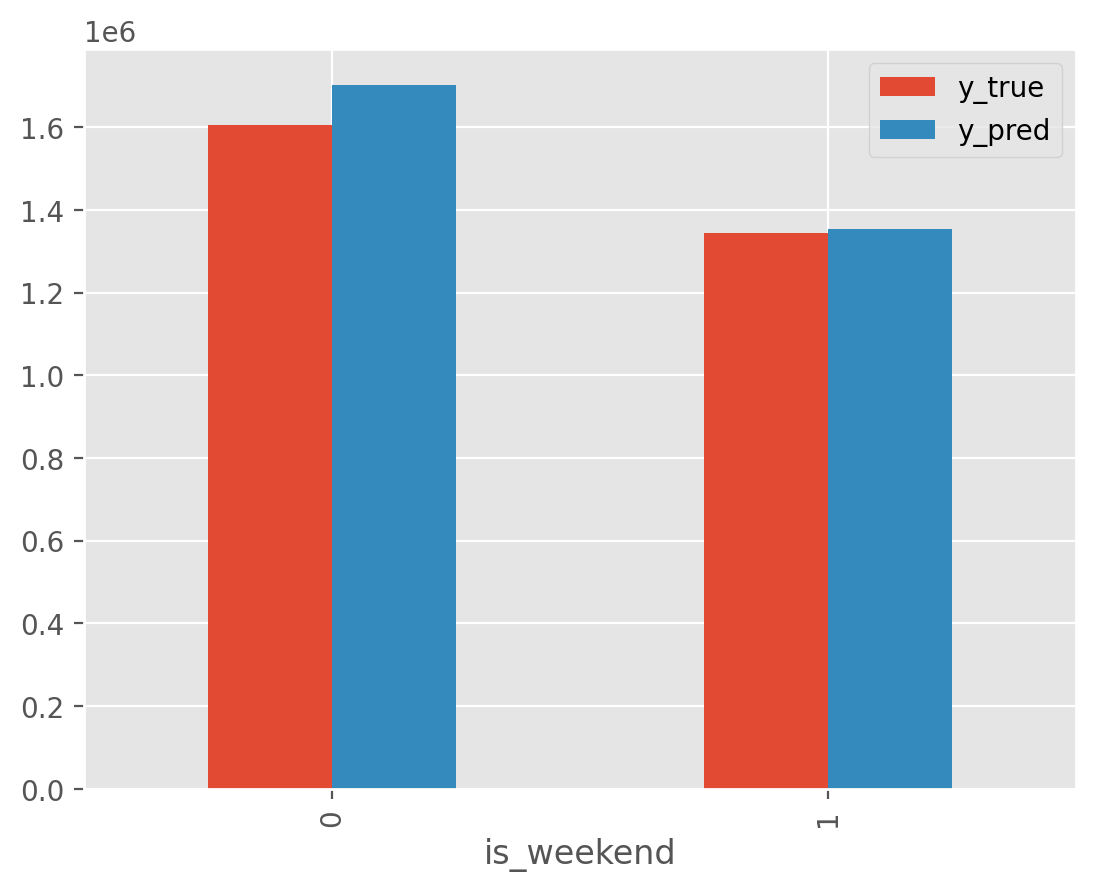

In [191]:
test_df[['is_weekend','y_true', 'y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar');